In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you use \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().system('pip install google-cloud-bigquery')
get_ipython().system('pip install google-cloud-bigquery[pandas]')

zsh:1: no matches found: google-cloud-bigquery[pandas]


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

CONFIGURE THE BIGQUERY SETTINGS

In [5]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [6]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [7]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [8]:
X = data.drop("total_claims",1)   #Feature Matrix
X = data.drop("week_number",1)
y = data["total_claims"]          #Target Variable

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_7647/2197130880.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop("total_claims",1)   #Feature Matrix
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_7647/2197130880.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop("week_number",1)


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_7647/3471576772.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


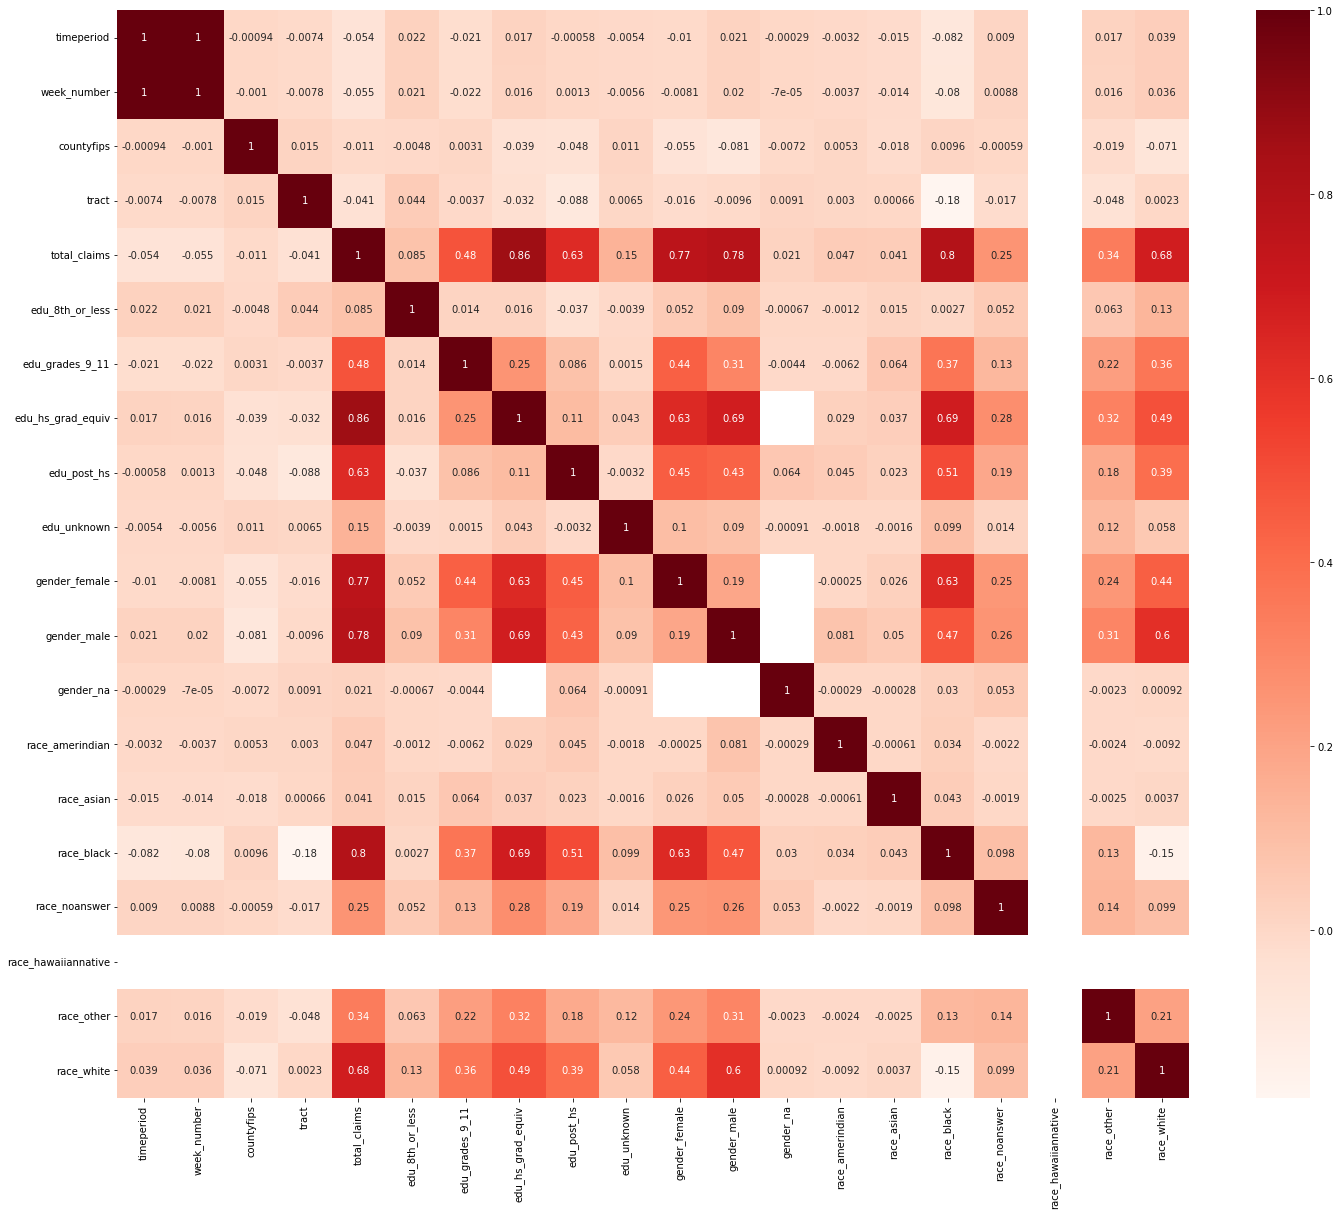

In [9]:
plt.figure(figsize=(24,20))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

total_claims         1.000000
edu_hs_grad_equiv    0.863481
edu_post_hs          0.629552
gender_female        0.767174
gender_male          0.783093
race_black           0.795195
race_white           0.683659
Name: total_claims, dtype: float64


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

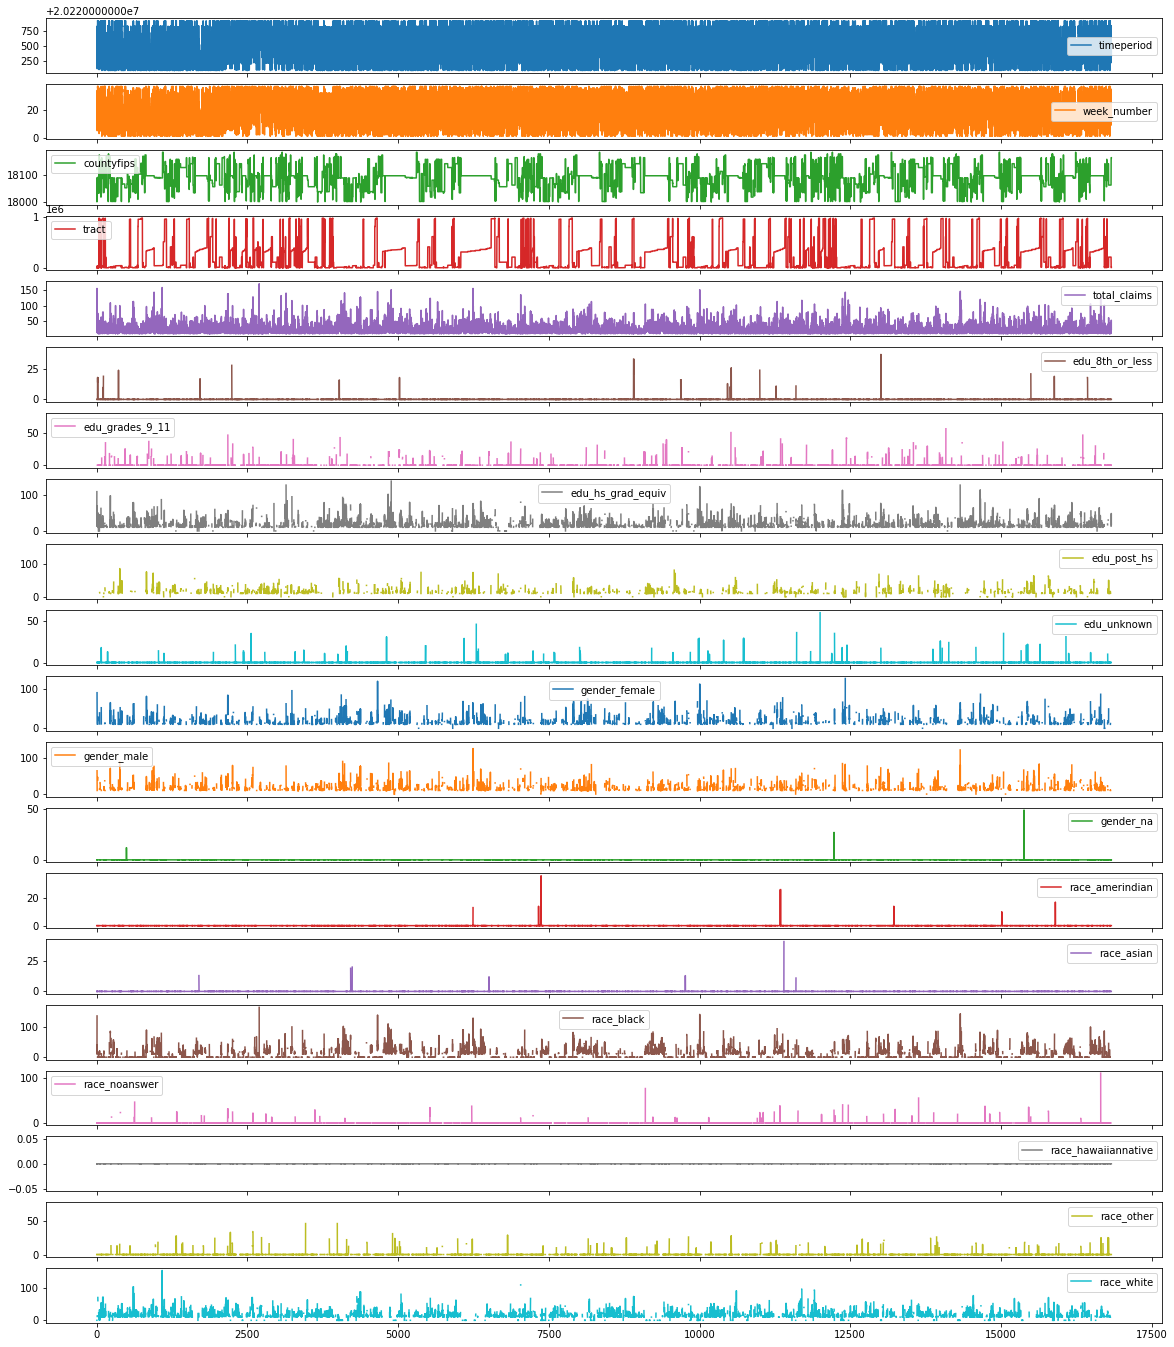

In [11]:
data.plot(subplots=True, figsize=(20,24))

In [12]:
min(data['week_number']),max(data['week_number'])

(1, 37)

In [13]:
data.dtypes

uu_id                     object
timeperiod                 Int64
week_number                Int64
countyfips                 Int64
tract                      Int64
tract_name                object
total_claims               Int64
edu_8th_or_less            Int64
edu_grades_9_11            Int64
edu_hs_grad_equiv          Int64
edu_post_hs                Int64
edu_unknown                Int64
top_category_employer1    object
top_category_employer2    object
top_category_employer3    object
gender_female              Int64
gender_male                Int64
gender_na                  Int64
race_amerindian            Int64
race_asian                 Int64
race_black                 Int64
race_noanswer              Int64
race_hawaiiannative        Int64
race_other                 Int64
race_white                 Int64
dtype: object

In [14]:
data = data.set_index('week_number')

In [15]:
data.index

Index([16, 12, 13, 29, 15, 34, 34,  5, 29, 24,
       ...
       25, 13, 18,  9, 17, 25, 35, 35, 13, 16],
      dtype='Int64', name='week_number', length=16833)

In [16]:
data.sample(37, random_state=0)

,uu_id,timeperiod,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
week_number,,,,,,,,,,,,,,,,,,,,,
14,06c78e49b4daedfeb808c42e58fb25e4,20220402,18063,210603,"Census Tract 2106.03, Hendricks County, Indiana",45,0,0,21,24,...,22,23,0,0,0,19,0,0,0,26
17,19c0ba2728a6971ff9c1301f3bf17f59,20220423,18065,976400,"Census Tract 9764, Henry County, Indiana",10,0,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,0,<NA>
9,dacd3e932f6546f12ba6b7f3e711a0ed,20220226,18097,310311,"Census Tract 3103.11, Marion County, Indiana",16,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,<NA>,0
25,07306ce64b3496b7955efaaf7509d73c,20220618,18053,10800,"Census Tract 108, Grant County, Indiana",13,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,0,<NA>
32,89399fcb71863c561d2a2703d8bd4a15,20220806,18033,20300,"Census Tract 203, DeKalb County, Indiana",44,0,<NA>,37,<NA>,...,<NA>,<NA>,0,0,0,0,0,0,0,44
10,ce9d46e559d5457a59ce3b288f2f8e7d,20220305,18143,967100,"Census Tract 9671, Scott County, Indiana",14,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,<NA>,<NA>
2,6877b5946ab2ee471e4c546252057f29,20220108,18097,360405,"Census Tract 3604.05, Marion County, Indiana",46,<NA>,<NA>,18,22,...,23,23,0,0,0,29,<NA>,0,<NA>,12
5,58313733000358ab97030c3688616a8b,20220129,18057,110809,"Census Tract 1108.09, Hamilton County, Indiana",16,0,0,<NA>,11,...,<NA>,<NA>,0,0,<NA>,<NA>,<NA>,0,0,<NA>
32,a0c62bdce75bc5e1d047eae6ab6046ad,20220806,18097,340112,"Census Tract 3401.12, Marion County, Indiana",25,<NA>,<NA>,13,<NA>,...,<NA>,<NA>,0,0,0,17,<NA>,0,<NA>,<NA>


In [17]:
data.loc[37]

,uu_id,timeperiod,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
week_number,,,,,,,,,,,,,,,,,,,,,
37,6657c9871fa2f67cd168e6f94354060e,20220910,18039,900,"Census Tract 9, Elkhart County, Indiana",50,18,<NA>,21,<NA>,...,11,39,0,0,0,0,0,0,<NA>,<NA>
37,6657c9871fa2f67cd168e6f94354060e,20220910,18039,900,"Census Tract 9, Elkhart County, Indiana",50,18,<NA>,21,<NA>,...,11,39,0,0,0,0,0,0,<NA>,<NA>
37,3934b01a1e31d0a6af96867e1afbf03c,20220910,18039,1100,"Census Tract 11, Elkhart County, Indiana",50,<NA>,<NA>,30,<NA>,...,16,34,0,0,0,0,<NA>,0,<NA>,44
37,3934b01a1e31d0a6af96867e1afbf03c,20220910,18039,1100,"Census Tract 11, Elkhart County, Indiana",50,<NA>,<NA>,30,<NA>,...,16,34,0,0,0,0,<NA>,0,<NA>,44
37,601ff2c0fd709298f6644ad0e766b2d6,20220910,18141,1100,"Census Tract 11, St. Joseph County, Indiana",20,0,<NA>,10,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,<NA>,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,447d5984bb8a8179bff002ccd1bba162,20220910,18081,610802,"Census Tract 6108.02, Johnson County, Indiana",10,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0,0,0,<NA>,<NA>
37,7dd5fff353cd08adc694aa74d7fa31af,20220910,18063,210202,"Census Tract 2102.02, Hendricks County, Indiana",13,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0,0,0,0,13
37,7dd5fff353cd08adc694aa74d7fa31af,20220910,18063,210202,"Census Tract 2102.02, Hendricks County, Indiana",13,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0,0,0,0,13


In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

ValueError: could not convert string to float: 'f013068de98db1470bd986137a0c6d23'

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [19]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

ValueError: could not convert string to float: 'f013068de98db1470bd986137a0c6d23'

In [21]:
y_pred = pd.Series(model.predict(X), index=X.index)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.